<table style="float:left; border:none">
   <tr style="border:none; background-color: #ffffff">
       <td style="border:none">
           <a href="http://bokeh.pydata.org/">     
           <img 
               src="assets/bokeh-transparent.png" 
               style="width:50px"
           >
           </a>    
       </td>
       <td style="border:none">
           <h1>Bokeh 教程</h1>
       </td>
   </tr>
</table>

<div style="float:right;"><h2>A2. 使用Datashader可视化大数据 </h2></div>

Bokeh通过将来自Python（或R）的数据镜像到Web浏览器中来获得它的力量。 这种方法提供了完全的灵活性和交互性，但是由于网页浏览器的设计和构建方式，以这种方式显示的数据量有限。 大多数网页浏览器在处理速度变慢或出现内存问题之前，可以处理大约10万或20万个数据点。 当您有更大的数据集时，怎么办？

[`datashader`](http://github.com/bokeh/datashader) 库旨在通过为超大型数据集提供可视化来补充Bokeh，专注于展示整体分布，而不仅仅是单个数据点。 datashader 的安装时与Bokeh分开的，使用命令 `conda install datashader`。

<img src="assets/datashader_examples.png">

## 什么时候 *不要* 使用 datashader

* 绘制小于1e5或1e6的数据点
* *每个* 数据点都很重要; 标准Bokeh将渲染所有数据点
* 对于 *每个* 数据点提供完全交互（悬停工具）

## 什么时候 *要* 使用 datashader

* 确实是 *大数据*，而Bokeh/Matplotlib力不从心时
* 当 *分布* 比单个点更重要
* 当您进行抽样或分档以更好地理解数据的 *分布*

# datashader 怎么工作?

<img src="https://raw.githubusercontent.com/bokeh/datashader/master/docs/images/pipeline2.png">

* Bokeh这样的工具直接将数据映射为 HTML/JavaScript 图表
* datashader将数据渲染成一个屏幕尺寸的聚合数组，从该数组可以构建一个图像，然后嵌入到Bokeh图中
* 只有固定大小的图像需要发送到浏览器，所以使得数百万甚至数十亿个数据点成为可能
* 每一步自动调整到数据，但可以自定义

# datashader 支持的可视化

Datashader 目前支持：

* 散列图/热图
* 时间序列
* 连接点（轨迹）
* 栅格

在各种情况下，输出都可轻松嵌入到Bokeh图中，并可为在notebook或应用程序中进行平移和缩放提供交互式重采样。 可以从聚合数组中生成图例/悬停信息，从而提供交互性。

# 真实地可视化大数据

一旦数据足够大以至于难以辨别个别点，以可靠的方式构建可视化至关重要，以忠实地揭示您的系统数据的底层分布。 例如，以下所有这些图都显示相同的数据 -- 它们中哪一个是真正的分布？

<img src="assets/5_gaussians_3_ways.png">

让我们把它找出来！ 上述图像中的数据是通过对五个正态（高斯）分布求和来创建的，如下所示：

In [1]:
import pandas as pd
import numpy as np

np.random.seed(1)
num=10000

dists = {cat: pd.DataFrame(dict(x=np.random.normal(x,s,num),
                                y=np.random.normal(y,s,num),
                                val=val,cat=cat))
         for x,y,s,val,cat in 
         [(2,2,0.01,10,"d1"), (2,-2,0.1,20,"d2"), (-2,-2,0.5,30,"d3"), (-2,2,1.0,40,"d4"), (0,0,3,50,"d5")]}

df = pd.concat(dists,ignore_index=True)
df["cat"]=df["cat"].astype("category")
df.tail()

cat  val         x         y
49995  d5   50 -1.397579  0.610189
49996  d5   50 -2.649610  3.080821
49997  d5   50  1.933360  0.243676
49998  d5   50  4.306374  1.032139
49999  d5   50 -0.493567 -2.242669

Here we have 50000 points, 10000 in each of five categories with associated numerical values.  This amount of data will be slow to plot directly with Bokeh or any similar libraries that copy the full data into the web browser.  Moreover, plotting data of this size with standard approaches has fatal flaws that make the above plots misrepresent the data:
在这里，我们有50000个点，五个类别中的每一个都有10000个相关的数值。这种数据量直接用Bokeh或任何类似的将全部数据复制到Web浏览器进行绘图的库速度会很慢。此外，用标准方法绘制这种大小的数据有致命的缺陷，导致上述图表歪曲数据：

* 图A 出现 _重叠绘图_ ，其分布被后绘制的数据点遮挡。
* 图B使用较小的点来避免重叠绘图，但出现 _过饱和_ ，数据点密度的差异不可见，因为所有高于某个值的密度显示为相同的纯黑色
* 图C使用透明度来避免过饱和，但出现 _欠饱和_ ，最大高斯（0,0）处的10,000个数据点根本不可见。
* Bokeh可以处理50,000点，但是如果数据较大，那么这些图会出现 *欠采样*，由于稀疏或放大区域中的数据点太少，分布不可见或误导。

图A-B还需要耗费时间且容易出错的手动参数调整，如果数据足够大以致可视化是我们理解数据的主要方式，则这是有问题的。

使用datashader，我们可以通过将数据渲染到允许在所有维度上进行自动测距的中间数组来避免所有这些问题，从而揭示真实的分布，无需参数调整且所需代码很少：

Wall time: 516 ms


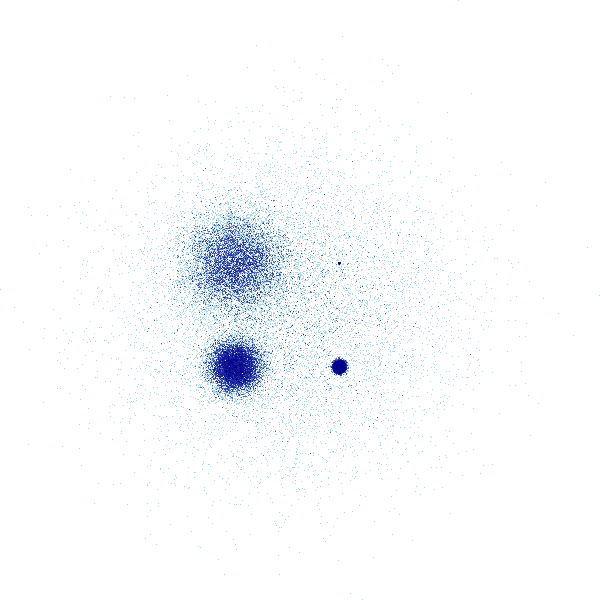

In [2]:
import datashader as ds
import datashader.transfer_functions as tf

%time tf.shade(ds.Canvas().points(df,'x','y'))

该图揭示了我们已知的结构，即5个独立的2D高斯分布：

<img src="assets/5_gaussians_labeled.png" width=200>

让我们依次查看 datashader 管道中的每个阶段，以查看如何构建这样的图像以及如何控制和嵌入到Bokeh图中。

# Projection and Aggregation（映射和聚合）

datashader 管道的第一个阶段是决定：

* 您想要在x和y轴上绘制哪些变量
* 你想要将这些值聚合到多大的数组中
* 该数组应覆盖哪些数据值范围，以及
* 你想用什么“降维”功能进行聚合

In [3]:
canvas = ds.Canvas(plot_width=250, plot_height=250, x_range=(-4,4), y_range=(-4,4))
agg = canvas.points(df, 'x', 'y', agg=ds.count())
agg

<xarray.DataArray (y: 250, x: 250)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * y        (y) float64 -3.984 -3.952 -3.92 -3.888 -3.856 -3.824 -3.792 ...
  * x        (x) float64 -3.984 -3.952 -3.92 -3.888 -3.856 -3.824 -3.792 ...

在这里，我们选择在x和y轴上绘制 dataframe 的'x'和'y'列（不出所料！），并通过 `count` 将它们聚合。其结果是所需大小的2D数组 [xarray](http://xarray.pydata.org/en/stable/computation.html)，包含每个最终像素的值，并计算映射到该像素的数据点数量。xarray和Numpy或Pandas的数据结构类似，支持类似的操作，但允许任意多维数据。

可用于聚合的可用降维函数包括：

**`count()`**: 对每个像素的数据点进行计数（默认的降维函数）

**`any()`**: 对于每个像素，如果有任何数据点映射到它，为1; 否则为0
  
**`sum(column)`**: 对映射到此像素的所有数据点，给定数据列的和

**`count_cat(column)`**: 使用给定的分类列（必须使用 [Pandas' `categorical` datatype](https://pandas-docs.github.io/pandas-docs-travis/categorical.html)) 进行声明），对 _每个分类_ 的数据点进行计数

In [4]:
# EXERCISE: try some of these other reduction operators and see if you can understand the 
# resulting differences in the plots.  The arr can be visualized using `tf.shade(arr)` 
# for most reduction operators (other than count_cat, below).


# Transformation（转换）

一旦数据处于xarray聚合格式中，就可以通过多种方式处理数据，从而提供灵活性和强大功能。 例如，我们不绘制所有的数据，而是可以很轻松地绘制出第99个百分点的数据：

D:\ProgramData\Anaconda3\envs\bokeh-notebooks\lib\site-packages\xarray\core\dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
D:\ProgramData\Anaconda3\envs\bokeh-notebooks\lib\site-packages\xarray\core\dtypes.py:25: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif np.issubdtype(dtype, int):


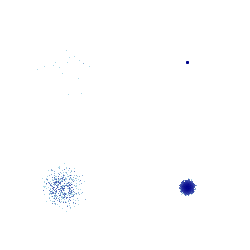

In [5]:
tf.shade(agg.where(agg>=np.percentile(agg,99)))

或者将任意 [NumPy ufunc](http://docs.scipy.org/doc/numpy/reference/ufuncs.html) 应用于bin值，无论它是否有意义：

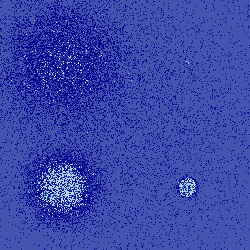

In [6]:
tf.shade(np.sin(agg))

可以为同一的绘图范围创建多个聚合，从而可以轻松表达比较复杂的查询（例如，`agg1.where(agg2>2*agg1)`）。

In [7]:
# EXERCISE: try making new aggregates using other numpy ufuncs


# 图着色

想要显示的聚合数组准备好后，您需要将该数组中的值转换为像素颜色。datashader支持所有Bokeh调色板或颜色列表：

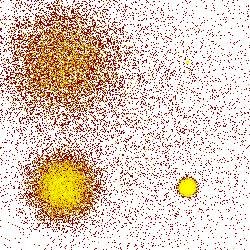

In [8]:
tf.shade(agg, cmap=["darkred", "yellow"])

我们可以选择数据值如何映射为颜色：'linear', 'log' 或 'eq_hist'：

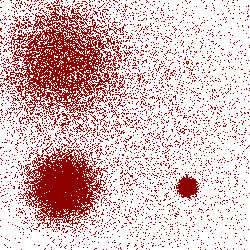

In [9]:
tf.shade(agg,cmap=["darkred", "yellow"],how='linear')

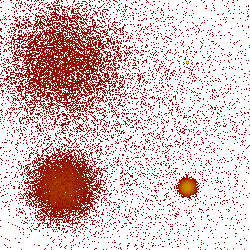

In [10]:
tf.shade(agg,cmap=["darkred", "yellow"],how='log')

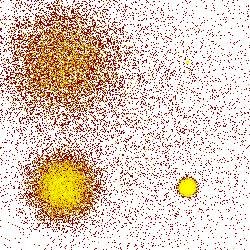

In [11]:
tf.shade(agg,cmap=["darkred", "yellow"],how='eq_hist')

请注意，linear线性情况下颜色范围很少，因为亮色（黄色）仅用于具有最高密度的单个像素，而线性映射导致所有其余像素点的值都接近颜色表中的暗色调。log映射有类似的问题，但稍好些，因为它将广泛的数据值映射到图的较小范围。`eq_hist` 设置（默认值）正确表达了各分布之间的密度差异，方法是均衡像素值的直方图，使每个像素颜色的使用频率相同。


如果你有一个分类聚合（来自 `count_cat`），你现在可以对其着色：

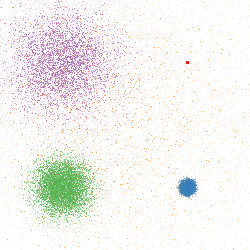

In [13]:
color_key = dict(d1='blue', d2='green', d3='red', d4='orange', d5='purple')
aggc = canvas.points(df, 'x', 'y', ds.count_cat('cat'))
tf.shade(aggc, color_key)

在这里，每个像素的颜色被计算为落入该像素的那些数据点的颜色的加权平均值。

如果您无法看到这些点，可以通过对最终图像 “spread” 来增加它们的大小：

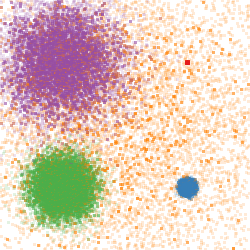

In [14]:
tf.spread(tf.shade(aggc, color_key))

`tf.spread` 使用固定（虽然可配置）的扩散尺寸，而类似的命令 `tf.dynspread` 将扩散不同的尺寸，取决于该视图中的图的密度。


# Embedding（嵌入）

datashader生成的图像可以用于任何绘图或显示程序，但我们在Bokeh中为datashader提供特定支持，允许完全交互式缩放和平移以探索超大数据集。
我们只需要将上面的命令包装到回调函数中，然后将其添加到Bokeh图中即可：

In [16]:
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(-5,5), y_range=(-5,5))

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.count_cat('cat'))
    img = tf.shade(agg, color_key)
    return tf.dynspread(img, threshold=0.25)

InteractiveImage(p, image_callback)

Loading BokehJS ...

您现在可以看到轴值（在纯图像中不可见）。如果启用滚轮缩放，则可以放大绘图的任何区域，此时将使用回调函数渲染新的datashader图像并显示在图中。例如，如果您放大蓝点，则可以看到它包含10,000个点，它们之间的距离非常接近，因此它们在这里仅显示为一个小蓝点。这种探索对于理解不同粒度结构丰富的数据集至关重要，大多数现实世界的数据就是这样。

现在，您可以轻松地将任何其他Bokeh数据叠加到同一图上，或将地图图块放在背景中以Web Mercator格式显示地理数据（请参见教程10）。

Datashader对于线图（例如，时间序列和轨迹）的工作方式类似，使您可以使用 *所有* 数据点而无需对其进行二次抽样，即使是数百万或数十亿个点，也可真实地覆盖成千上万或数百万条单独曲线，而不会有过饱和问题。它还可以使用光栅数据（如卫星天气数据），重新光栅化为需要的栅格进行分析或着色，然后与其他非光栅化的数据合并。例如，如果您有光栅格式的海拔数据，收入数据作为独立点，则可以轻松制作出平均收入超过特定阈值且海拔低于某个特定值的所有像素的图形，这样的可视化使用传统的工作流程很难表达。

希望您现在清楚如何使用datashader来处理大数据集。更多信息，请参阅datashader在线文档 [extensive notebooks](https://anaconda.org/jbednar/notebooks)，其中包括许多不同的真实世界数据集的示例。